In [1]:
import matplotlib.pyplot as pl
import pandas as pd
import rules.enzymes_v04 as enz
enzymes = [item for item in dir(enz) if not item.startswith("__")]

pl.rcParams["font.family"] = "sans-serif"
pl.rcParams["font.size"] = 10

In [2]:
reports = ['v04_Rac1_dominant', 
           'v04_RhoA_dominant']

In [3]:
def plot_knockdowns(dataframe, ax, title, maxn):
    colors = ['#1f77b4', '#ff7f0e']
    
    dataframe = dataframe[['Actin_BR', 'Actin_ST']]
    
    ax = dataframe.plot.bar(width=0.8, color=colors, ax=ax)
    ax.legend(loc='lower right', bbox_to_anchor=(0.97, 1.0), ncol=2, 
              frameon=False, borderpad=0, borderaxespad=0,
              prop={'size':10})

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('left')

    ax.set_ylim(top=100)
    ax.set_ylabel('Weighted activity, %')
    ax.set_xlim(-0.5, maxn-0.5)
    ax.set_title(title, loc='left', x=0.03)
    br, st = dataframe.loc['base']

    ax.plot([-1, 100], [br, br], linewidth=1, linestyle='--', color=colors[0])
    ax.plot([-1, 100], [st, st], linewidth=1, linestyle='--', color=colors[1])

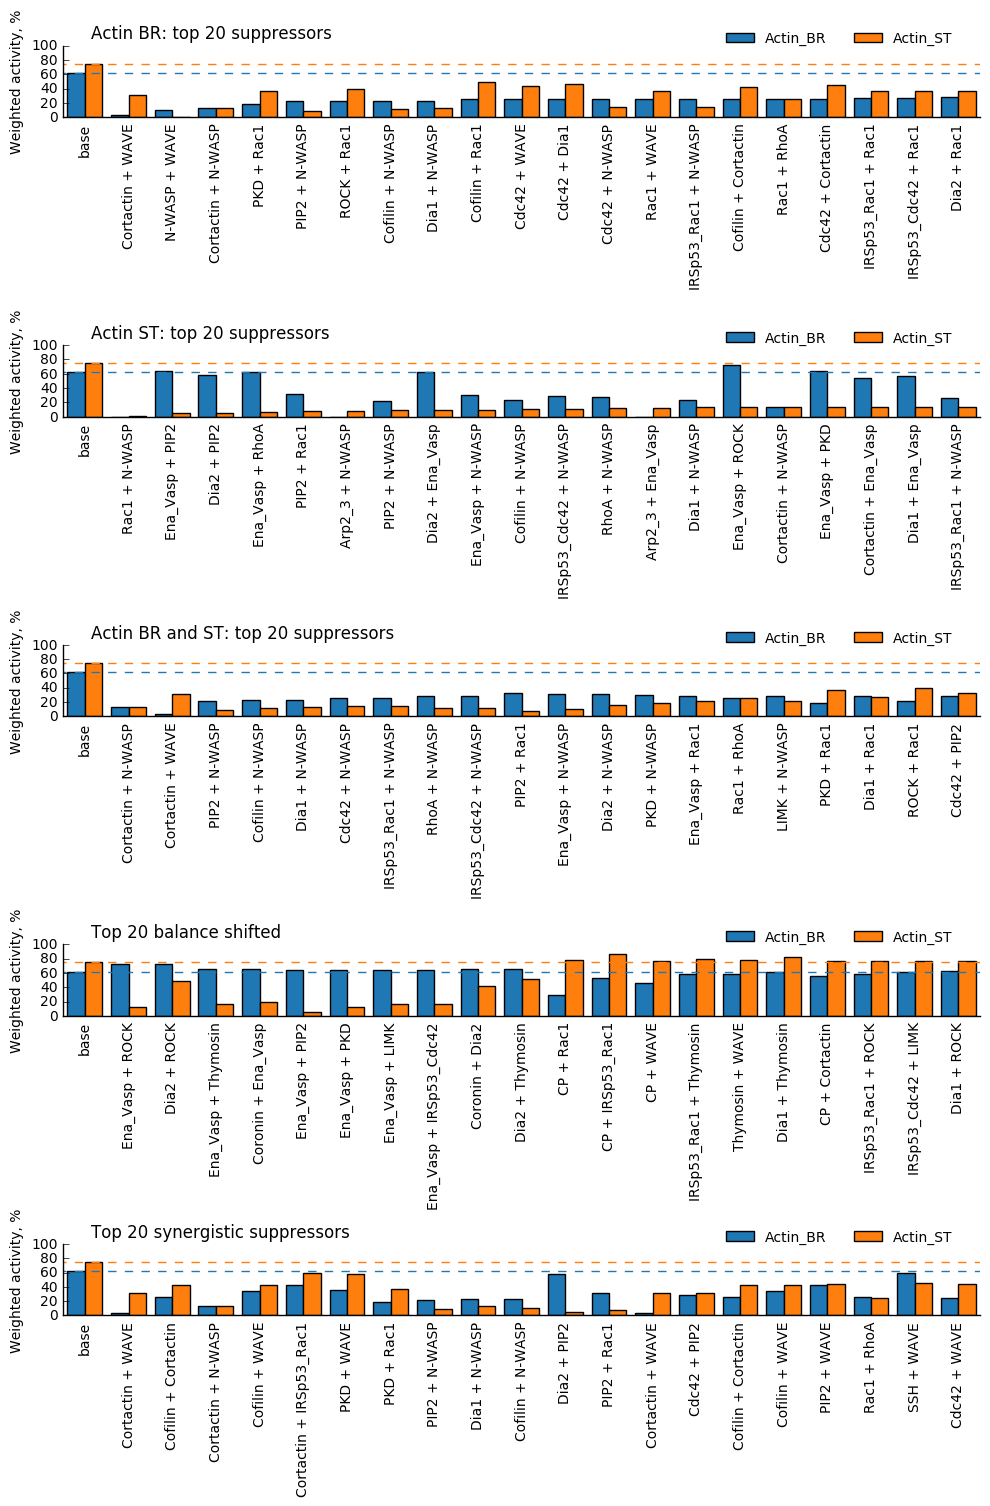

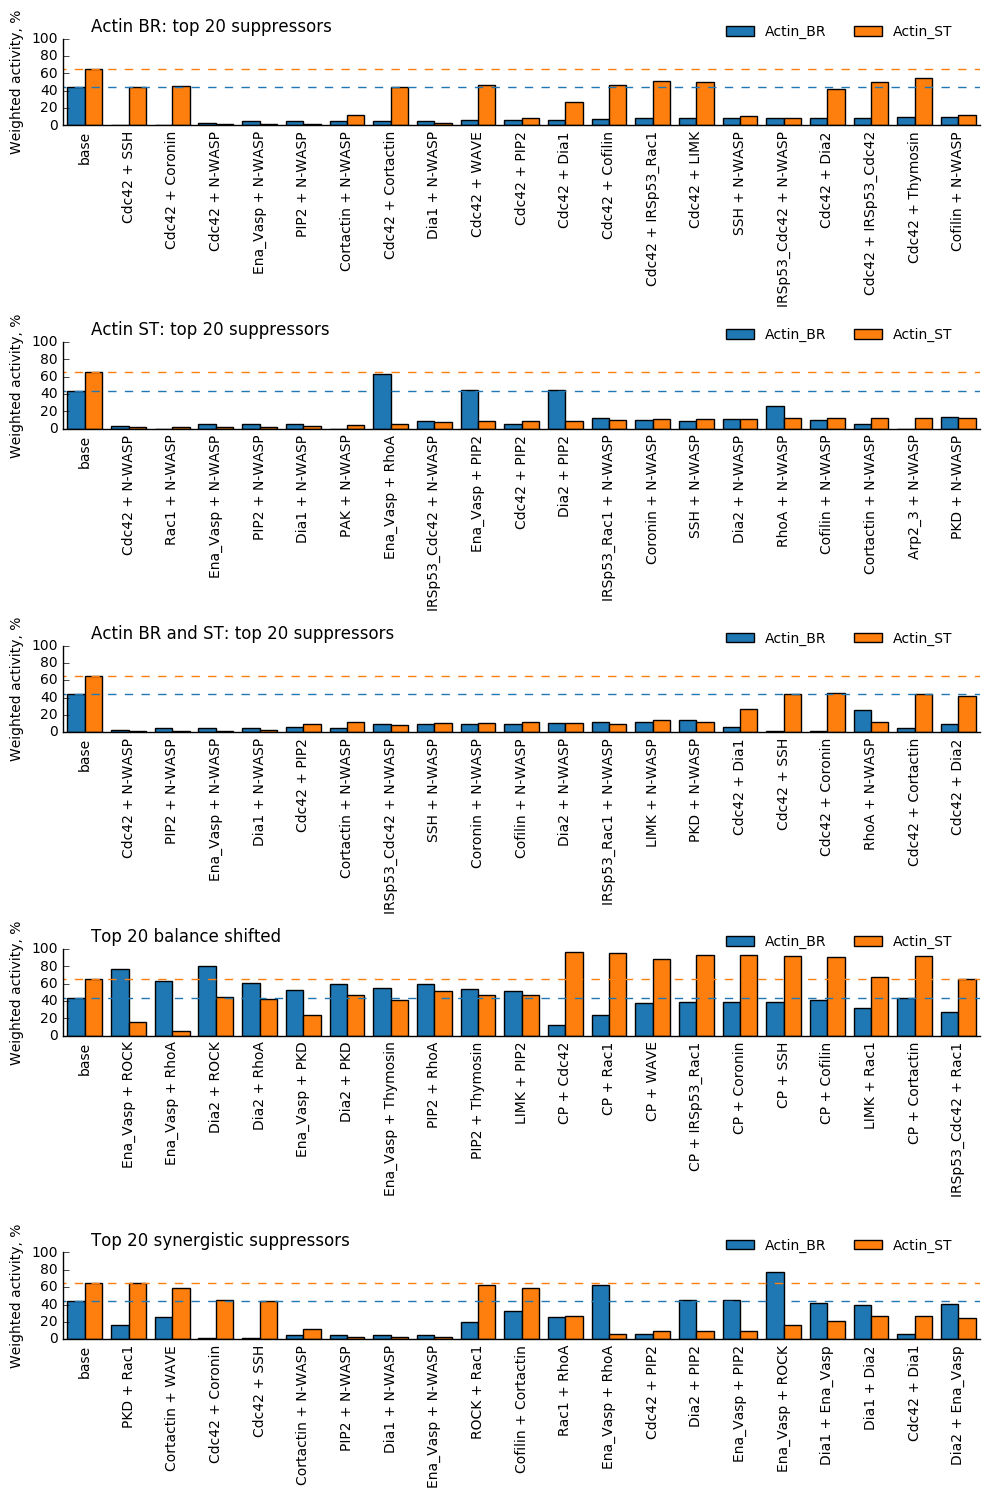

In [20]:
def get_single_kd_values(row, singles):    
    if row.name == 'base':
        return 0
    
    nodes = row.name.split(' + ')    
    return min(singles[nodes[0]], singles[nodes[1]])

topX = 20

for report in reports:
    df = pd.read_csv('reports/{}/summary.csv'.format(report), index_col=0)    
    df_single = df.filter(regex='^({0})$'.format('|'.join(enzymes))).loc[[enz.Actin_BR, enz.Actin_ST]]
    
    df = df.filter(regex='^(base|({0})_({0}))$'.format('|'.join(enzymes))).loc[[enz.Actin_BR, enz.Actin_ST]]
    df.columns = df.columns.str.replace(r'^({0})_({0})$'.format('|'.join(enzymes)), r'\g<1> + \g<2>').str.replace('WASP', 'N-WASP')
    df = df.transpose()
    
    base_BR = df['Actin_BR']['base']
    base_ST = df['Actin_ST']['base']
    
    df_single.columns = df_single.columns.str.replace('WASP', 'N-WASP')
    df_single = df_single.transpose()
        
    df['Actin_BR_diff'] = df['Actin_BR'] / base_BR - 1
    df['Actin_ST_diff'] = df['Actin_ST'] / base_ST - 1
    df['balance_shift'] = df['Actin_BR_diff'] * df['Actin_ST_diff']
    df['both_diff'] = df['Actin_BR_diff'] + df['Actin_ST_diff']
    

    df['Actin_BR_single'] = df.apply(get_single_kd_values, axis=1, args=(df_single['Actin_BR'],))
    df['Actin_ST_single'] = df.apply(get_single_kd_values, axis=1, args=(df_single['Actin_ST'],))

    df['synergy_BR'] = (df['Actin_BR'] - df['Actin_BR_single']) / base_BR
    df['synergy_ST'] = (df['Actin_ST'] - df['Actin_ST_single']) / base_ST
#     df['synergy'] = df['synergy_BR'] + df['synergy_ST']
    
    dfs = [
        df[df.index == 'base'].append(
            df[df['Actin_BR'] > 0].sort_values('Actin_BR').head(topX)),
        
        df[df.index == 'base'].append(
            df[df['Actin_ST'] > 0].sort_values('Actin_ST').head(topX)),
        
        df[df.index == 'base'].append(
            df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0)].sort_values('both_diff').head(topX)),
        
        df[df.index == 'base'].append([
            df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0) & (df['Actin_BR_diff'] > 0)] \
                .sort_values('balance_shift').head(topX // 2),
            df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0) & (df['Actin_ST_diff'] > 0)] \
                .sort_values('balance_shift').head(topX // 2)]),
        
        df[df.index == 'base'].append([
                df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0)].sort_values('synergy_BR').head(topX // 2),
                df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0)].sort_values('synergy_ST').head(topX // 2)
            ]),
            
    ]

    names = [r'Actin BR: top {} suppressors'.format(topX), 
             r'Actin ST: top {} suppressors'.format(topX), 
             r'Actin BR and ST: top {} suppressors'.format(topX), 
             r'Top {} balance shifted'.format(topX),
             r'Top {} synergistic suppressors'.format(topX)
            ]

    fig, axis = pl.subplots(5, 1, sharey=True, figsize=(10, 15))

    
    for i in range(5):
        plot_knockdowns(dfs[i], axis[i], names[i], topX+1)

    pl.tight_layout()

    pl.savefig('charts/fig_4_top_X_{}.png'.format(report), bbox_inches='tight', dpi=300)
    pl.savefig('charts/fig_4_top_X_{}.svg'.format(report), bbox_inches='tight')
    pl.savefig('charts/fig_4_top_X_{}.eps'.format(report), bbox_inches='tight')
